# Actual Transformer Autoencoder Implementation

Here we will use proper `keras.Layer` and `tf.Model` abstractions to implement a realistic MVP for the transformer autoencoder. 

## Framing 
...

## Diverging: System setup
 - **Layer**: Transformer block. 
	 - Sublayer 1: MHA + layernorm. 
	 - Sublayer 2: FFN + layernorm. 
	 - NOTE: Must call `MHA._build_from_signature()` function in `build()` of the transformer block layer. 
	 - Input: Keys, values. 
 - Encoder: Progressively compressing the `M x D` input to `N x C` with transformer blocks. 
	 - Query: __learnable__ positional encoding for the `N x C` dimension. 
	 - Several __distinct__ transformer blocks with `query` = positional encoding, `key-value` = input byte array. 
	 - Finally: cross attention between {input, current latent embedding} -> {new latent}. 
 - Latent->latent: Self attention transformer block. 
	 - Adjustable number of distinct blocks -> `superblock`. 
	 - Adjustable number of `superblock_repeats`. 
	 - Adjustable frequency of inserting the `encoder` signal again. 
 - Decoder: Query = `M x D` positional encoding; key-values = `latent`. 
	 - Adjustable number of re-querying cycles. 
	 - Adjustable number of re-exposures to the latent values(?)
	 - Option for using a _learned_ query rather than constant positional encoding... 
	 	 - Only really makes sense for _full_ autoencoding -- not for partial recover in Vision NCA-style.

## Converging: MVP System 
 - **Transformer Layer**: Still required. 
 - **Encoder**: One transformer block with `query` = latent/learned initial latent, `key-value` = input byte array.
 - **Decoder**: One transformer block with `query` = positional encoding for original array, `key-value` = latent array. 
 - **Latent evolver**: # unique blocks and # repeats are still adjustable...
 - We will leave adjustable re-querying/etc. to the next iteration. We just need this one to function. 

> BIG GOAL: Overfit to a couple of training examples. Show that it can reconstruct an image or something. 
 - __Next__: Once we have the patch->video thing running, we can try it on a properly patched/encoded video. For now, we will just use a single frame with each row as a token. 

## 0: Data Acquisition & Imports

In [1]:
## Import Box 
import os 
import sys 
import random
import pathlib
import itertools
import collections
import math

import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
# Some modules to display an animation using imageio.
import imageio

2022-10-07 17:42:18.889138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 17:42:19.013135: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-07 17:42:19.052002: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-07 17:42:19.553381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
## GPU Setup
physical_devices = tf.config.list_physical_devices("GPU")
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


In [3]:
## Get some data 
# Utility imports  
sys.path.append("../src")
import video_loader as vl
import video_preprocess as vp 

## Meta/constants 
DATA_FOLDER = "../datasets/downloads"
num_videos, num_frames = 2, 20
output_size = (120, 180)

patch_height = 16
patch_width = 16
patch_duration = 3

batch_size=1

# Fourier feature codes 
k_space = 15
mu_space = 20 
k_time = 64 
mu_time = 200

print("Getting VideoSet...")
VideoSet = vl.get_videoset("../datasets/downloads", num_videos, num_frames, output_size=output_size)

print("Making patches from Videoset...")
PatchSet = vp.make_patchset(VideoSet, patch_duration, patch_height, patch_width)

print("Making the flat patch set...")
FlatPatchSet = vp.patch_to_flatpatch(PatchSet, batch_size=batch_size)

print("Adding codes to the PatchSet...")
CodedPatchedSet = PatchSet.map(lambda x: vp.add_spacetime_codes(x, 
		k_space=k_space, mu_space=mu_space, k_time=k_time, mu_time=mu_time))

print("Flattening the coded + patched dataset...")
FlatCodedPatchedSet = vp.patch_to_flatpatch(CodedPatchedSet, batch_size=batch_size)

Getting VideoSet...


  0%|          | 0/2 [00:00<?, ?it/s]2022-10-07 17:42:20.550544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 17:42:21.490386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19396 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-10-07 17:42:21.490975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22279 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:68:00.0, compute capability: 8.6
100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Making patches from Videoset...
Making the flat patch set...
Flattening a tensor of shape:  (None, 6, 7, 11, 2304)
Adding codes to the PatchSet...
Flattening the coded + patched dataset...
Flattening a tensor of shape:  (1, 6, 7, 11, 2495)


Text(0.5, 1.0, 'Positionally encoded image')

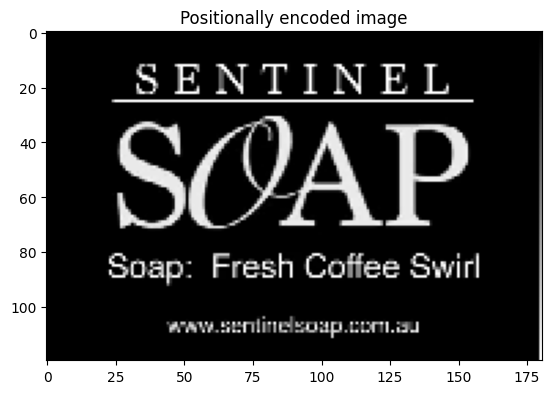

In [10]:
## Obtaining a single greyscale frame from a video

video_num = 2

# Getting a candidate frame 
cnt = 0
for element in VideoSet: 
	cnt += 1
	if cnt == video_num:
		candidate_frame = element
		break

reconstruct_me = candidate_frame[:, -1, :,:,0]
# plt.imshow(reconstruct_me[0,:,:], cmap='gray')
# plt.title("Let's use the rows of this as tokens!")
# plt.colorbar()
# print("Reconstruct_me shape: ", reconstruct_me.shape)

## Now with basic positional encoding
video_height = reconstruct_me.shape[-2]
pos_code = tf.range(0, 1, 1/video_height) 
pos_code = tf.expand_dims(pos_code, axis=0)
pos_code = tf.expand_dims(pos_code, axis=-1)

poscode_reconstruct_me = tf.concat([reconstruct_me, pos_code], axis=2)
poscode_reconstruct_me.shape
plt.imshow(poscode_reconstruct_me[0,:,:], cmap='gray')
plt.title("Positionally encoded image")


## 1: Transformer Layers 

In [31]:
class TFLayer(keras.layers.Layer):
	def __init__(self, input_dim, output_dim=None, n_heads=15, key_dim=15, mha_dropout=0.0): 
		""" Transformer block. 

		args: 
			`input_dim`: 	Input dim for the pointwise MLP. The hidden layer will be 4x this. 
		kwargs: 
			`output_dim`: 	Dimensionality of the output tokens. If unspecified, defaults to `input_dim`. 
			`n_heads`:		Number of heads in the MHA layer. 
			`key_dim`:		Dimensionality of keys within the MHA layer. 
			`mha_dropout`: 	Dropout rate for the multihead attention layer. 
		"""
		super(TFLayer, self).__init__() 

		if output_dim == None: 
			output_dim = input_dim

		value_dim = input_dim # values outputted by the MHA layer 

		self.MHA = keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=value_dim, dropout=mha_dropout)
		self.conv1 = keras.layers.Conv1D(input_dim*4, 1, activation="relu")
		self.conv2 = keras.layers.Conv1D(output_dim, 1, activation="linear") 

		# TODO: Double check that this is normalizing along the right axes.
		self.layer_norm = tf.keras.layers.LayerNormalization()

	def build(self, input_shape): 
		# self.MHA._build_from_signature(input_shape)
		... # TODO: How does this `build_from_signature` thing work? 

	def call(self, queries, keys): 
		""" Invokes the transformer block on the given queries and keys. 
		"""
		mha_out = self.MHA(queries, keys)
		print("mha_out_shape_1: ", mha_out.shape)
		if queries.shape == keys.shape:
			mha_out = self.layer_norm(mha_out + queries)

		ffn_out = self.conv1(mha_out) 
		print("ffn_out_1 shape: ", ffn_out.shape)
		ffn_out = self.conv2(ffn_out) 
		print("ffn_out_2 shape: ", ffn_out.shape)

		if ffn_out.shape == mha_out.shape:
			return self.layer_norm(ffn_out + mha_out)
		return self.layer_norm(ffn_out)

### Test 1: Self Attention on Image 

In [32]:
poscode_reconstruct_me.shape

TensorShape([1, 120, 181])

In [33]:
input_dim = poscode_reconstruct_me.shape[-1]
test_block = TFLayer(input_dim)

mha_out_shape_1:  (1, 120, 181)
ffn_out_1 shape:  (1, 120, 724)
ffn_out_2 shape:  (1, 120, 181)


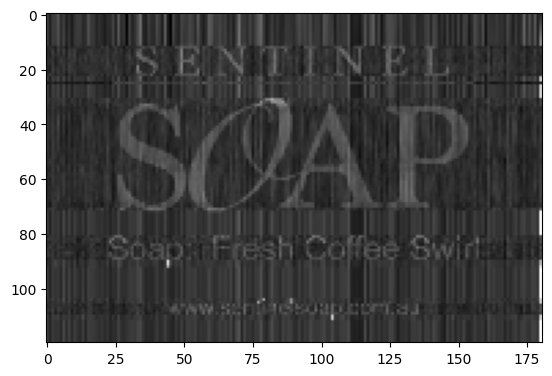

In [34]:
block_out = test_block(poscode_reconstruct_me, poscode_reconstruct_me)
plt.imshow(block_out[0,:,:], cmap='gray')

### Test 2: Projecting Down to Latent Dim

In [35]:
## Single set of positional codes: 
N, C = 32, 48
_, M, D = poscode_reconstruct_me.shape

num_idx = N
k = C
mu = 30

codes = vp.get_fourier_codes(num_idx, k, mu)
codes = tf.expand_dims(codes, axis=0)
print("Codes shape: ", codes.shape)

print("N, C = ", (N, C))
print("M, D = ", (M, D))

Codes shape:  (1, 32, 97)
N, C =  (32, 48)
M, D =  (120, 181)


In [36]:
input_dim = 181
output_dim = C # 48 -- output of FFN layer
encoder_block = TFLayer(input_dim, output_dim=C)

mha_out_shape_1:  (1, 32, 97)
ffn_out_1 shape:  (1, 32, 724)
ffn_out_2 shape:  (1, 32, 48)
Encoder output shape:  (1, 32, 48)
Desired output shape N x C:  (32, 48)


Text(0.5, 1.0, 'Encoder Output')

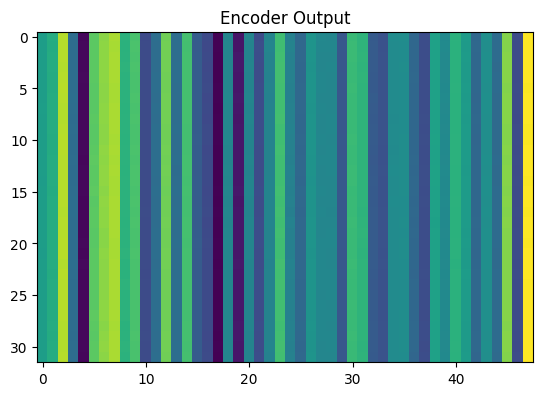

In [46]:
encoder_output = encoder_block(codes, poscode_reconstruct_me)
print("Encoder output shape: ", encoder_output.shape)
print("Desired output shape N x C: ", (N, C))
plt.imshow(encoder_output[0,:,:])
plt.title("Encoder Output (untrained)")

Text(0.5, 1.0, 'Positional Codes')

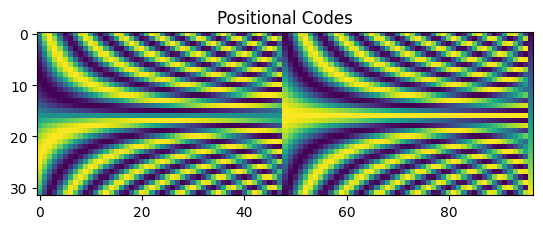

In [48]:
plt.imshow(codes[0,:,:])
plt.title("Positional Codes")

### Test 3: Projecting Up from Latent Dimension

In [54]:
input_dim = encoder_output.shape[-1] # dimensionality of each token

decoder_block = TFLayer(input_dim, output_dim=D)

k_out, mu_out = 15, M/2
positional_queries = vp.get_fourier_codes(M, k, M)
positional_queries = tf.expand_dims(positional_queries, axis=0)
positional_queries.shape

TensorShape([1, 120, 97])

mha_out_shape_1:  (1, 120, 97)
ffn_out_1 shape:  (1, 120, 192)
ffn_out_2 shape:  (1, 120, 181)
Decoder output shape:  (1, 120, 181)


Text(0.5, 1.0, 'Decoder Output (untrained)')

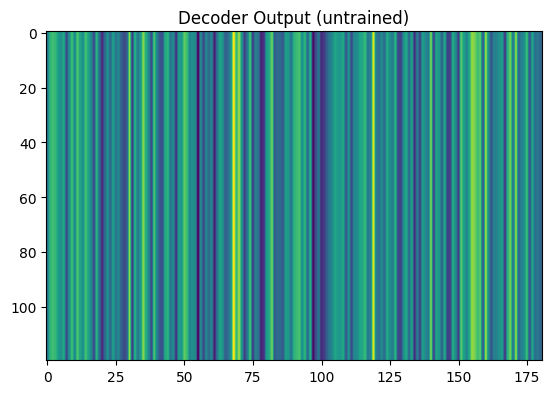

In [60]:
decoder_out = decoder_block(positional_queries, encoder_output) 
print("Decoder output shape: ", decoder_out.shape)
plt.imshow(decoder_out[0,:,:])
plt.title("Decoder Output (untrained)")

In [59]:
poscode_reconstruct_me.shape

TensorShape([1, 120, 181])

## 2: Perceiver Model